- number of cores, set this number according to your computer

In [62]:
from stock_helper import *
from stats import *
from imp import reload  
import stock_helper
import stats
reload(stock_helper)
reload(stats)


<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [63]:
import warnings
 
warnings.filterwarnings('ignore')

- sample product, you can change to your specific product symbol

In [64]:
product_list = ["600276","000538",  "600332", "600436", "600535"]
product = product_list[0]

In [65]:
import dask
from dask import compute, delayed

In [66]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM
## 16

16

- get the list of this form

In [68]:
DATA_PATH = HEAD_PATH + "/stock pkl/"
all_dates = list(map(lambda x: x,os.listdir(DATA_PATH + product_list[0])))
n_days = len(all_dates)
n_days
## 5

5

- number of days

In [377]:
all_dates


array(['2016.pkl', '2017.pkl', '2018.pkl', '2019.pkl', '2020.pkl'],
      dtype='<U8')

- some days may have error because of rolling contracts

- we randomly choose a day

- plot all the data

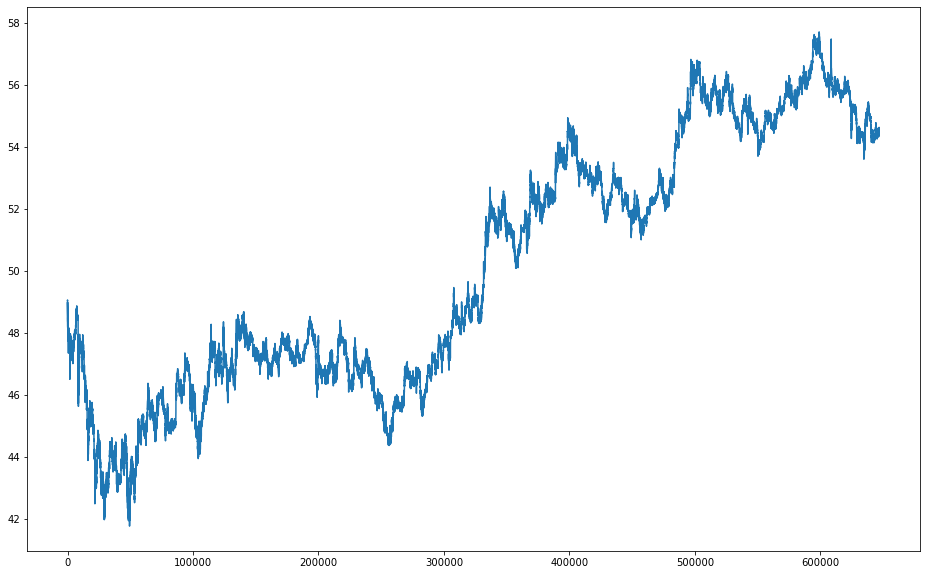

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

data = load(DATA_PATH + product_list[0] + "/"+all_dates[0])
plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values);

- Welcome to Quantitative and High Frequency Trading Training Program


- number of usable points

In [72]:
period = 4096

- the first signal is the buy/sell imbalance signal


- create directory for all signals

- create directory for the product

In [73]:
SAVE_PATH = "e:/intern"

In [74]:
import os
for product in product_list:
    os.makedirs(SAVE_PATH + "/tmp pkl/" + product, exist_ok=True)

- create directory for the signal

- now let's check the signal


- it's the buy/sell imbalance of one tick

- zero_divide is zero when denominator is zero
- we can see the definition of zero_divide in helper.py


- returns 0 if the numerator or denominator is 0

In [75]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

In [98]:
## calculate the range of price
## there may be several periods of range here, divided by wpr
## look-back periods are in period_list
## typically, 1024, 2048, 4096
## for index futures, 1024 may be useful
## for black commodities, 2048 may be useful
## for other commodities, 4096 may be useful
## here we use 4096
def get_atr(file, product, period_list):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/data["wpr"]
        save(S, SAVE_PATH+"/tmp pkl/"+product+"/atr."+str(period)+"/" + file[-8:])

In [77]:
## calculate exponential moving avergae
## may different from python's ewm
## warning: adjust is NOT the adjust of ewm
## the adjust of ewm is ALWAYS False
## look-back period is halflife in ewma
## halflife is the period of alpha decay to half
## this is only one method to calculate ewma, there are others, suchas (n-1)/(n+1) and 2/(n+1)
## if adjust=false, the first (period-1) values may be too large
## so we use adjust=true to adjust it, it's divided by aa
## and the first (period-1) values are normal in value
def ewma(x, halflife, init=0, adjust=False):
    init_s = pd.Series(data=init)
    s = init_s.append(x)
    if adjust:
        xx = range(len(x))
        lamb=1 - 0.5**(1 / halflife)
        aa=1-np.power(1-lamb, xx)*(1-lamb)
        bb=s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]
        return bb/aa
    else:
        return s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]

In [78]:
## to calculate the normalized return
## class of factor
## 3 parts: factor_name, params, formula
## 2^[10:13]=(1024,2048,3096)
## the idea is ret/|ret|
## then over a period, we divided by period in numerator and denominator
## (ret/period)/(|ret|/period)
## then we use ewma(ret)/ewma(|ret|) instead of mean return
## because calculate ewma is faster and easier
## but the first period items may not be correct for ewma
## so we use adjust=True
## but since there is avdivision, actually we don't need to use adjust=True
## they would be the same with or withour adjust=True
from collections import OrderedDict
class foctor_nr_period(factor_template):
    factor_name = "nr.period"
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True)).values

In [79]:
## procedure to calculate a signal
## first use a variable to define the class object
x3 = foctor_nr_period()
SAVE_PATH = "e:/intern"
## then create directories to save the result
for product in product_list:
    create_signal_path(x3, product, SAVE_PATH);
    
#e:/intern/tmp pkl/600276/nr.1024
#e:/intern/tmp pkl/600276/nr.2048
#e:/intern/tmp pkl/600276/nr.4096
#e:/intern/tmp pkl/000538/nr.1024
#e:/intern/tmp pkl/000538/nr.2048
#e:/intern/tmp pkl/000538/nr.4096
#e:/intern/tmp pkl/600332/nr.1024
#e:/intern/tmp pkl/600332/nr.2048
#e:/intern/tmp pkl/600332/nr.4096
#e:/intern/tmp pkl/600436/nr.1024
#e:/intern/tmp pkl/600436/nr.2048
#e:/intern/tmp pkl/600436/nr.4096
#e:/intern/tmp pkl/600535/nr.1024
#e:/intern/tmp pkl/600535/nr.2048
#e:/intern/tmp pkl/600535/nr.4096

e:/intern/tmp pkl/600276/nr.1024
e:/intern/tmp pkl/600276/nr.2048
e:/intern/tmp pkl/600276/nr.4096
e:/intern/tmp pkl/000538/nr.1024
e:/intern/tmp pkl/000538/nr.2048
e:/intern/tmp pkl/000538/nr.4096
e:/intern/tmp pkl/600332/nr.1024
e:/intern/tmp pkl/600332/nr.2048
e:/intern/tmp pkl/600332/nr.4096
e:/intern/tmp pkl/600436/nr.1024
e:/intern/tmp pkl/600436/nr.2048
e:/intern/tmp pkl/600436/nr.4096
e:/intern/tmp pkl/600535/nr.1024
e:/intern/tmp pkl/600535/nr.2048
e:/intern/tmp pkl/600535/nr.4096


In [95]:
for product in product_list:
    for period in [1024,2048,4096]:
        os.makedirs(SAVE_PATH + "/tmp pkl/" + product+"/atr."+str(period), exist_ok=True)

In [80]:
file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product))) ## files of each day

In [83]:
%%time 
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product))) ## files of each day
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3, product=product, HEAD_PATH=SAVE_PATH, n=8)
;
# Wall time: 1min 1s



Wall time: 1min 1s


''

- we can check the result

- we can see that they are the same
- so the signal calculation process is correct


- now calcualte all the value of this signal

In [84]:
import statsmodels.tsa.stattools as ts
import math

In [88]:
signal_name = "nr.4096"
period = 4096
for product in product_list:
    all_signal = np.array([])
    all_dates = list(map(lambda x: x,os.listdir(DATA_PATH + product)))
    n_days = len(all_dates)
    for file in np.array(all_dates):
        data = load(HEAD_PATH+"/stock pkl/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        all_signal = np.concatenate((all_signal, S), axis=0)
    sample_signal = all_signal[np.arange(1,len(all_signal)+1)% period==0]
    result = ts.adfuller(sample_signal, maxlag=int(pow(len(sample_signal)-1,(1/3))), regression='ct', autolag=None)
    print(product, "adf", result)
    result = ts.kpss(sample_signal, regression='c', lags=int(3*math.sqrt(len(sample_signal))/13))
    print(product, "kpss", result)
    
#600276 adf (-9.076198373701603, 2.442757131170254e-13, 10, 1092, {'1%': -3.967084327352913, '5%': -3.4145181252526546, '10%': -3.1294210742584307})
#600276 kpss (0.19852268267193512, 0.1, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
#000538 adf (-7.888962645841075, 1.2903878524048481e-10, 9, 780, {'1%': -3.9704235469980107, '5%': -3.4161336656341135, '10%': -3.1303713703029383})
#000538 kpss (0.0855679962705663, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
#600332 adf (-8.401503304024802, 8.453437158726483e-12, 9, 841, {'1%': -3.969575103796695, '5%': -3.415723303810561, '10%': -3.1301300222417643})
#600332 kpss (0.10967398967277965, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
#600436 adf (-8.179019117641227, 2.7558246991050383e-11, 9, 877, {'1%': -3.969129965194855, '5%': -3.4155079729768896, '10%': -3.1300033689651725})
#600436 kpss (0.158715773109418, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
#600535 adf (-7.632565696945016, 5.04510350760533e-10, 9, 737, {'1%': -3.971106390199908, '5%': -3.416463872525507, '10%': -3.1305655588156727})
#600535 kpss (0.06134732056091098, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

600276 adf (-9.076198373701603, 2.442757131170254e-13, 10, 1092, {'1%': -3.967084327352913, '5%': -3.4145181252526546, '10%': -3.1294210742584307})
600276 kpss (0.19852268267193512, 0.1, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
000538 adf (-7.888962645841075, 1.2903878524048481e-10, 9, 780, {'1%': -3.9704235469980107, '5%': -3.4161336656341135, '10%': -3.1303713703029383})
000538 kpss (0.0855679962705663, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
600332 adf (-8.401503304024802, 8.453437158726483e-12, 9, 841, {'1%': -3.969575103796695, '5%': -3.415723303810561, '10%': -3.1301300222417643})
600332 kpss (0.10967398967277965, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
600436 adf (-8.179019117641227, 2.7558246991050383e-11, 9, 877, {'1%': -3.969129965194855, '5%': -3.4155079729768896, '10%': -3.1300033689651725})
600436 kpss (0.158715773109418, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
600535 adf (-7.6325

- for adf, if p-valus(the second one) is small, then it's stationary;
- for kpss, if p-value is large, then it's stationary;
- so for trade.imb.4096, all of them are stationary
- now we calcualte another signal which measures the range ranther than direciton

In [90]:
def add_min_max(file, period_list):
    data = load(file)
    data = data.reset_index(drop=True)
    for period in period_list:
        data["min."+str(period)] = data["wpr"].rolling(period).min()
        data.loc[:period-1, ("min."+str(period))] = data["wpr"][0]
        
        data["max."+str(period)] = data["wpr"].rolling(period).max()
        data.loc[:period-1, ("max."+str(period))] = data["wpr"][0]
    save(data, file)

In [92]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, all_dates))
    parLapply(CORE_NUM, file_list, add_min_max, period_list=[1024, 2048, 4096])

#Wall time: 1min 18s

Wall time: 1min 18s


In [99]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=np.power(2, range(10,13))) 
    
# Wall time: 47.6 s

Wall time: 47.6 s


- It measures how many bid/ask spreads of range in the previous period 
- In this case, we can measure volatility of each product in similar criteron
- because slippage is the largest cost for intraday trading

- Then we can modify our backtest program to include a trend signal and a range signal

,open,close
0,0.20,-0.040
1,0.20,-0.080
2,0.20,-0.120
3,0.20,-0.160
4,0.20,-0.200
...,...,...
95,0.58,-0.116
96,0.58,-0.232
97,0.58,-0.348
98,0.58,-0.464


In [151]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.001, 0.02, 0.001)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))


In [356]:
from collections import OrderedDict
def get_signal_pnl(file, product, signal_name, thre_mat, reverse=1,  buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                   max_spread=0.011,
                   HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", atr_filter=0):
    ## load data
    data = load(HEAD_PATH+"/stock pkl/"+product+"/"+file)
    S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    pred = S*reverse
    atr = load(SAVE_PATH+"/tmp pkl/"+product+"/"+"atr.4096"+"/"+file)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    date = np.array([x[0:10] for x in data["date.time"]])
    next_date = np.append(date[1:],'1')
    end_day = date!=next_date
    count = 0;
    n_day = sum(end_day)
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((n_day, n_thre))
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)

    cur_spread = data["ask1"]-data["bid1"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        #change_pos = position - position.shift(1)
        #notional_change_pos = notional_position-notional_position.shift(1)
        change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        #notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        change_base[change_buy] = data["next.ask"][change_buy]*(1+buy_tranct)*data["adjust"]
        change_base[change_sell] = data["next.bid"][change_sell]*(1-sell_tranct)*data["adjust"]
        raw_pnl = -(change_base*change_pos).cumsum()+notional_position*data["wpr"]
        final_pnl = -sum(change_base*change_pos) ## total pnl, there is a negative sign, because selling get money and buying pay money
        turnover = sum(change_base*abs(change_pos))
        num = sum((position!=0) & (change_pos!=0)) ## number of trades
        hld_period = sum(position!=0)   ## holding period
        daily_pnl = raw_pnl[end_day].reset_index(drop=True)
        pnl = np.append(daily_pnl[0], np.diff(daily_pnl))
        all_pnl[:,thre[0]] = pnl
        if (num==0):
            result.loc[thre[0], ("num","avg.ret","ret")] = (0,0,0)
        else:
            result.loc[thre[0],("num", "avg.ret", "ret", )] = (num, final_pnl/num, final_pnl)
    return OrderedDict([("all.pnl", all_pnl), ("result", result), ("date", date[end_day])])

- First we want to know the range of signal

In [105]:

signal_name = "nr.4096"
all_product_signal = dict([])
for product in product_list:
    all_dates = list(map(lambda x: x,os.listdir(DATA_PATH + product)))
    n_days = len(all_dates)
    all_signal = np.array([])
    for file in np.array(all_dates):
        data = load(HEAD_PATH+"/stock pkl/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S[abs(S)>0.3] = 0
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_signal[product] = all_signal

- we can plot the range together in one graph

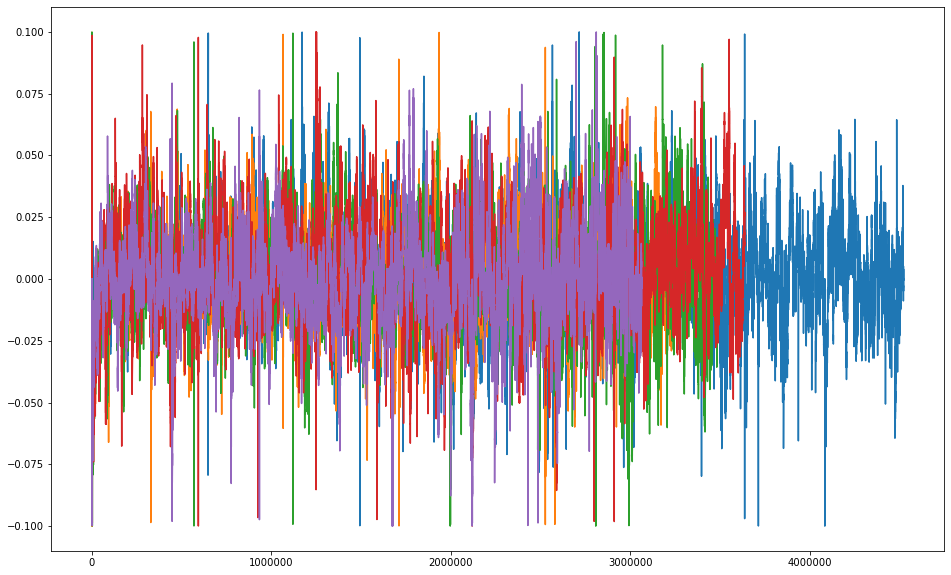

In [109]:
for product in product_list:
    plt.figure(1, figsize=(16, 10))
    signal = all_product_signal[product]
    signal[abs(signal)>0.1] = 0
    plt.plot(signal);

In [264]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.001, 0.02, 0.001)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

- then at the quantile values

In [345]:
from collections import OrderedDict
def get_hft_summary(result, thre_mat):
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((0,n_thre))
    all_dates = np.array([])
    for i in range(len(result)):
        all_pnl =  np.concatenate((all_pnl,result[i]["all.pnl"]),axis=0)
        all_dates = np.append(all_dates, result[i]["date"])
    stat = result[0]["result"].iloc[:,2:]
    for i in range(1,len(result)):
        stat = stat+result[i]["result"].iloc[:,2:]
    stat["avg.ret"]=stat["ret"]/stat["num"]
    
    total_ret = all_pnl.sum(0)
    total_sharpe = np.zeros(n_thre)
    total_drawdown = np.zeros(n_thre)
    total_max_drawdown = np.zeros(n_thre)
    for i in range(n_thre):
        total_sharpe[i] = sharpe(all_pnl[:,i])
        total_drawdown[i] = drawdown(all_pnl[:,i])
        total_max_drawdown[i] = max_drawdown(all_pnl[:,i])
    final_result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"]), ("close", thre_mat["close"]), ("num", stat["num"]),
                                                  ("avg.ret", stat["avg.ret"]), ("total.ret",total_ret), ("sharpe", total_sharpe),
                                                  ("drawdown", total_drawdown), ("max.drawdown", total_max_drawdown),
                                                 ("mar", total_ret/total_max_drawdown)]), 
                                index=thre_mat.index)
    return OrderedDict([("final.result", final_result), ("daily.pnl", all_pnl), ("date", all_dates)])


In [337]:

## chooose one day out of 10 days
signal_name = "atr.4096"
all_product_atr = dict([])
for product in product_list:
    all_dates = list(map(lambda x: x,os.listdir(DATA_PATH + product)))
    n_days = len(all_dates)
    all_signal = np.array([])
    for file in np.array(all_dates):
        data = load(HEAD_PATH+"/stock pkl/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file).reset_index(drop=True)
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_atr[product] = all_signal

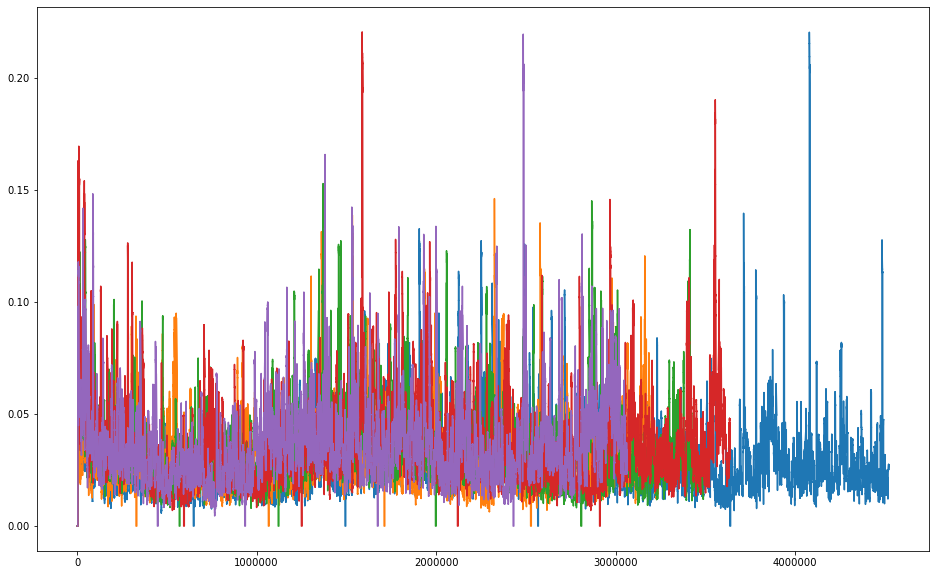

In [114]:
for product in product_list:
    plt.figure(1, figsize=(16, 10))
    plt.plot(all_product_atr[product]);

In [314]:
trade_stat = get_hft_summary(result, thre_mat)

In [357]:
%%time
signal_name = "nr.4096"
all_trade_stat = dict([])
for product in product_list:
    all_dates = list(map(lambda x: x,os.listdir(DATA_PATH + product)))
    n_days = len(all_dates)
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, 
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=0.02)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    all_trade_stat[product] = trade_stat

# Wall time: 11min 37s


Wall time: 11min 37s


In [358]:
save(all_trade_stat, HEAD_PATH+"/"+"medical_trade_stat_nr_4096.pkl")

- it seems the signal value leans to negative

- for example we care about the average pnl

In [359]:
all_trade_stat = load(HEAD_PATH+"/"+"medical_trade_stat_nr_4096.pkl")

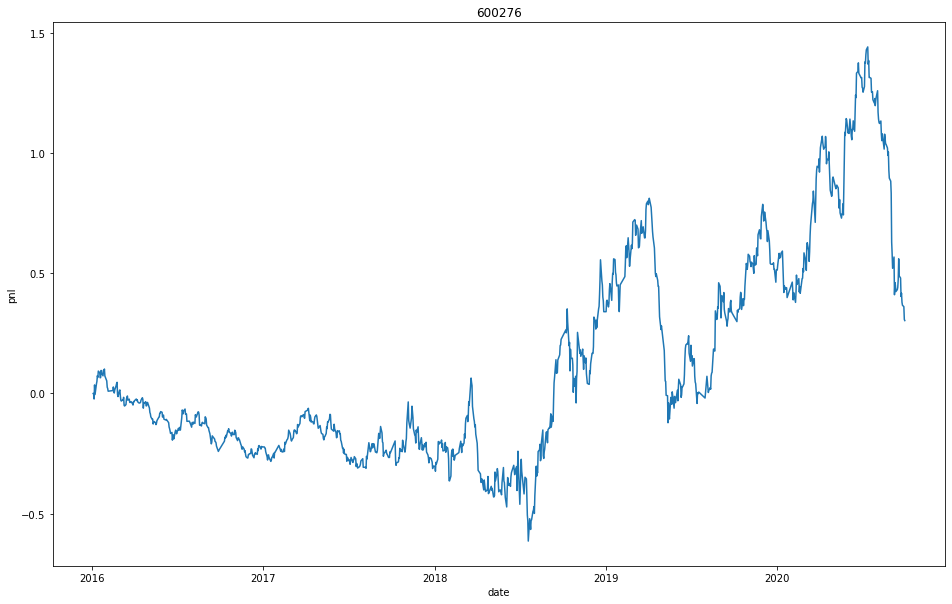

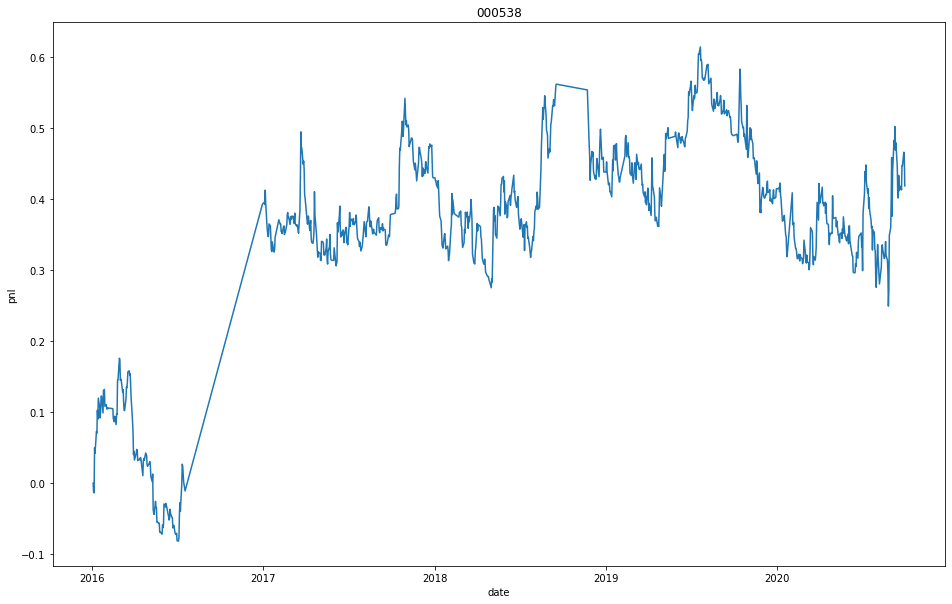

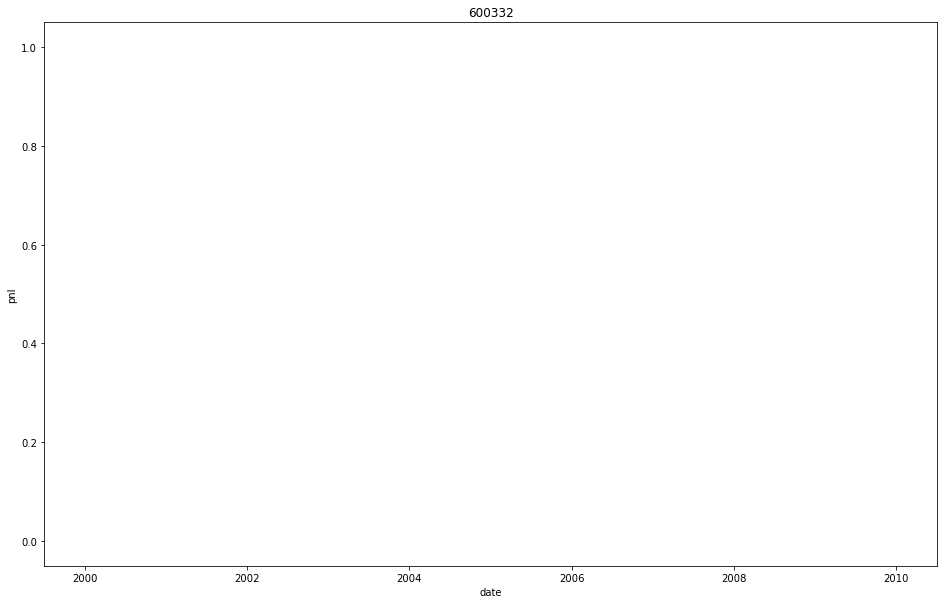

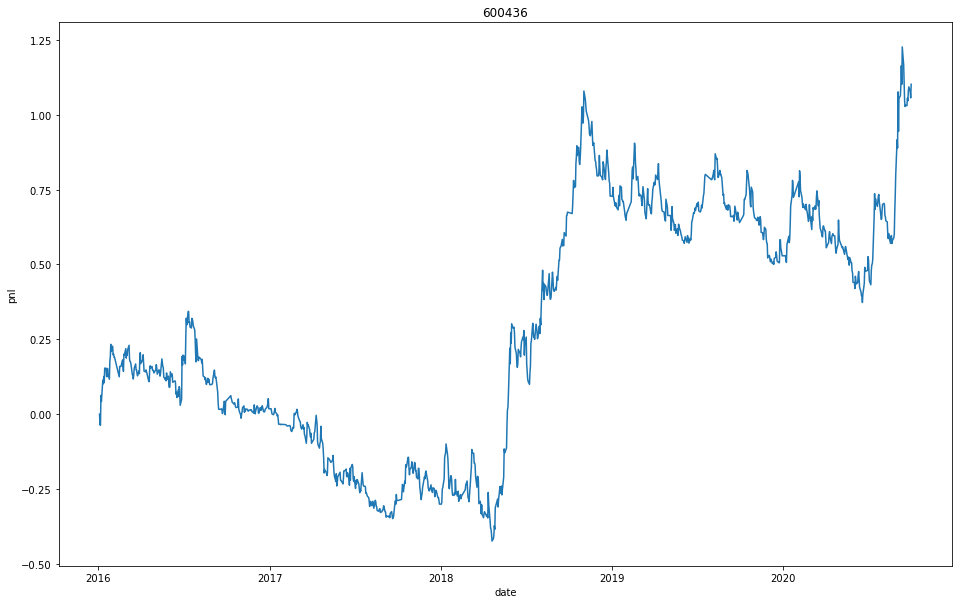

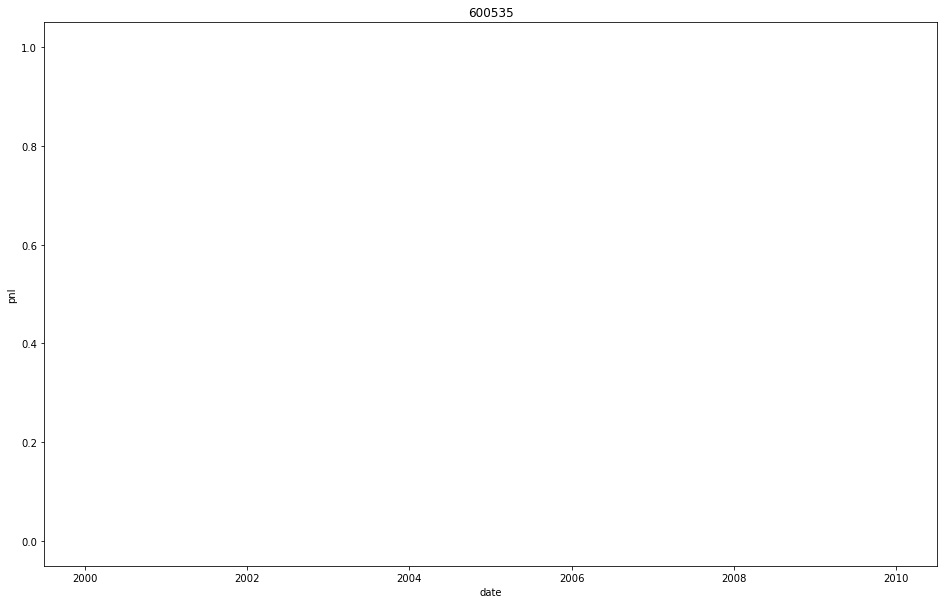

In [360]:
i = 0
for product in product_list:
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat["final.result"]["avg.ret"]>0.001
    good_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    format_dates = np.array([pd.to_datetime(d) for d in trade_stat["date"]])
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());

- get training samples

- now let's see the in-sample and out-of-sample performance


- the previous result used the whole data set 
- so it may be more optimistic than reality
- now we split the data into training sample and test sample


- at first let's remain 2018 as out-of-sample

- number of training samples

In [363]:
%%time
signal_name = "nr.4096"
train_trade_stat = dict([])
for product in product_list:
    all_dates = np.array(list(map(lambda x: x,os.listdir(DATA_PATH + product))))
    train_sample = all_dates<"2019"
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, 
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=0.02)
        result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    train_trade_stat[product] = trade_stat
    
# Wall time: 10min 55s


Wall time: 10min 55s


In [364]:
save(train_trade_stat, HEAD_PATH+"/medical_train_trade_stat.pkl")

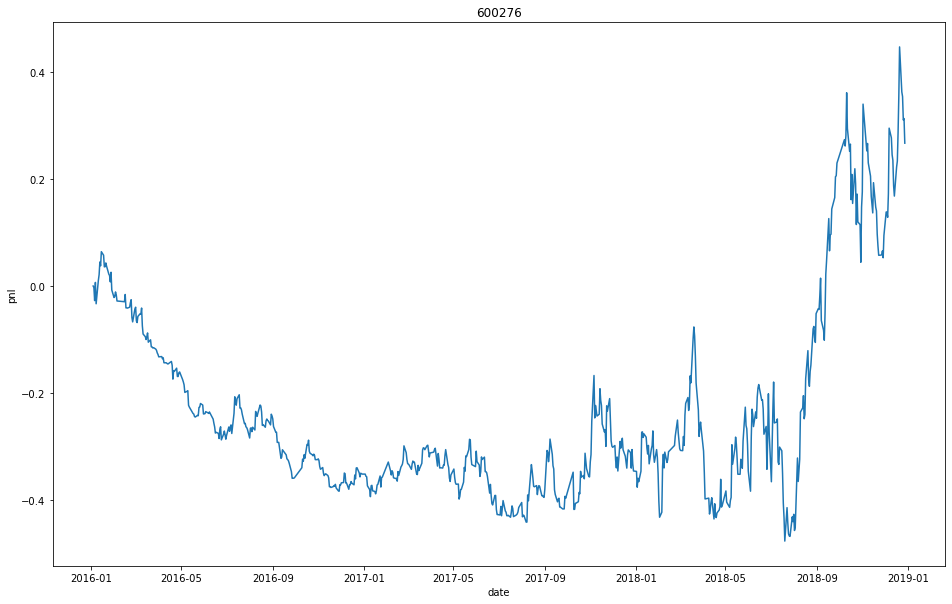

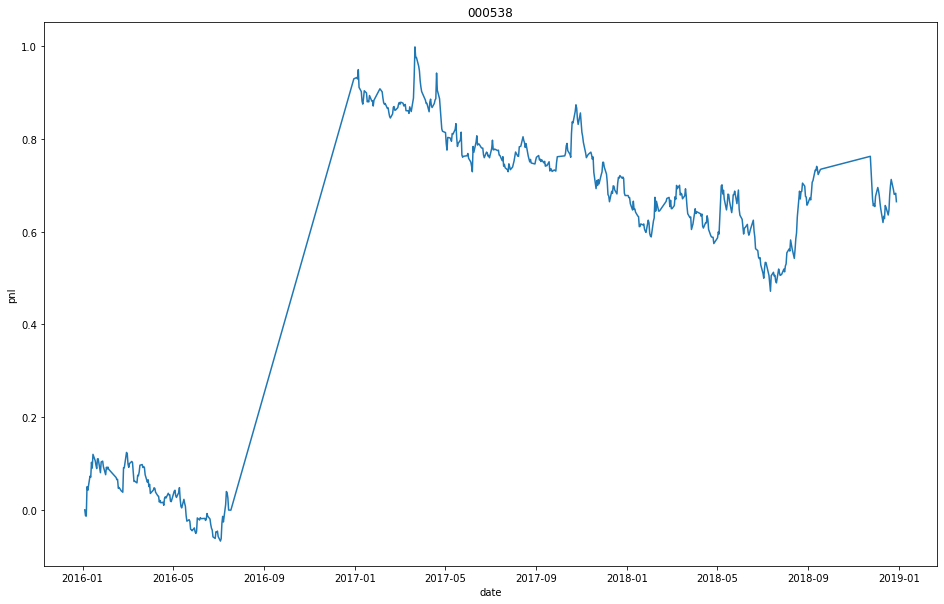

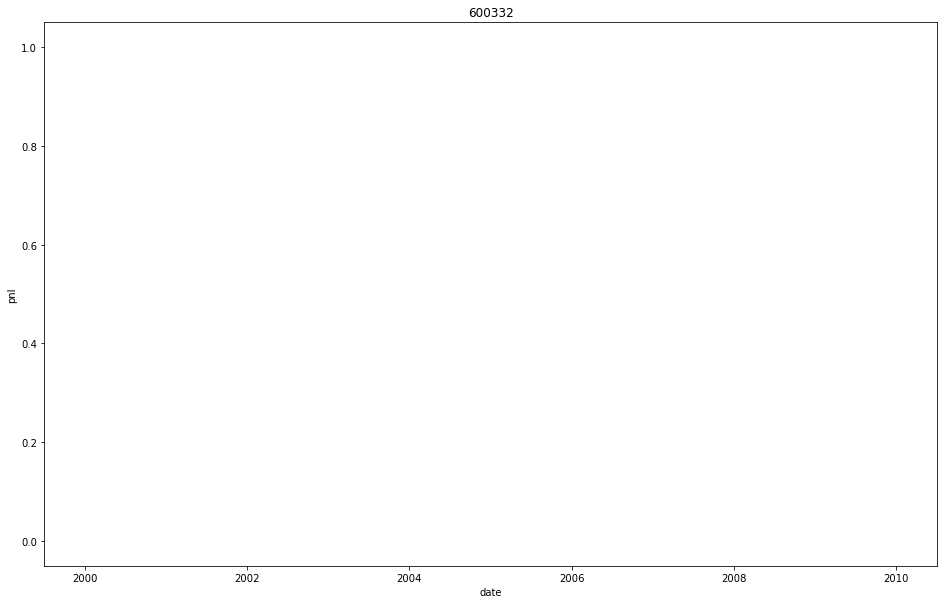

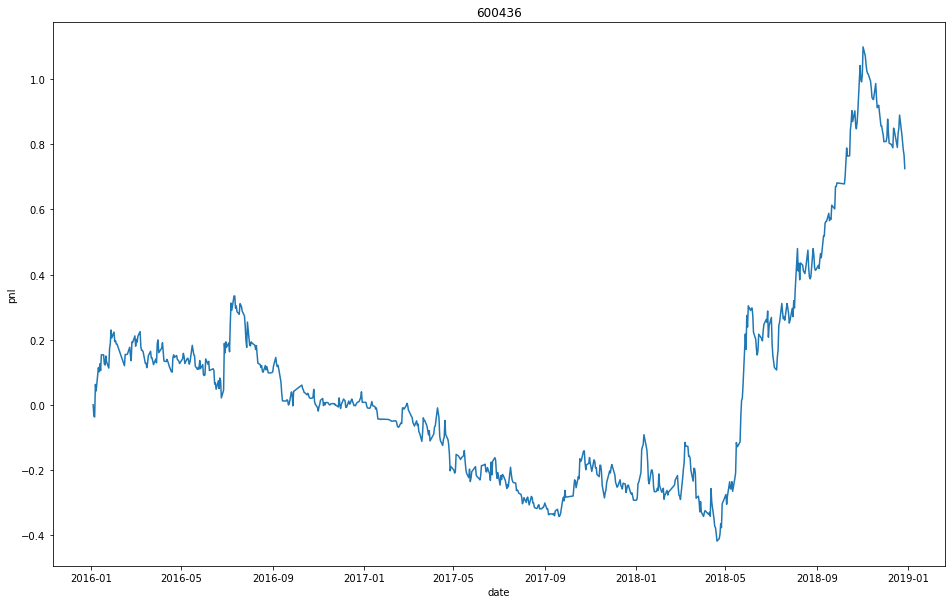

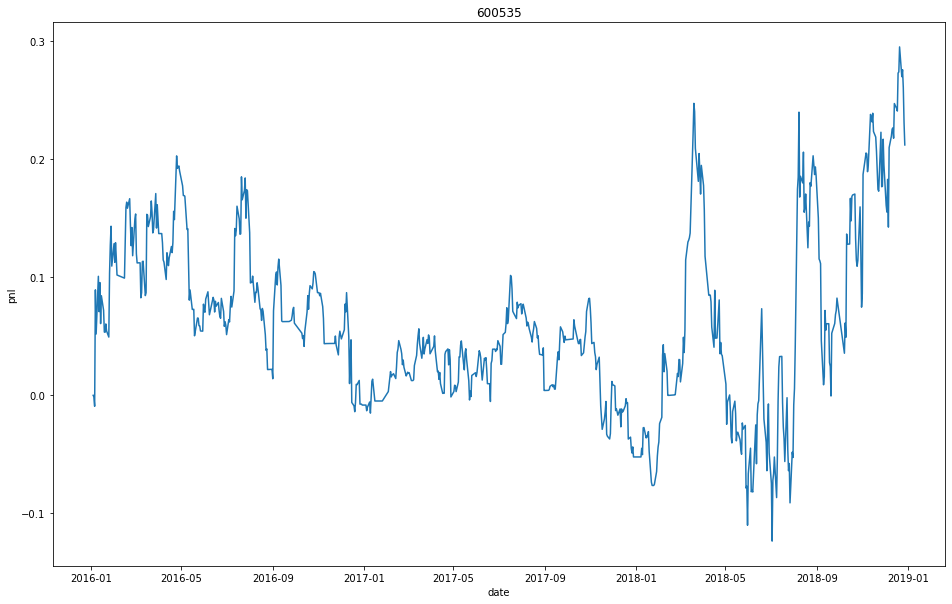

In [368]:
i = 0
all_trade_stat = load(HEAD_PATH+"/medical_train_trade_stat.pkl")
for product in product_list:
    trade_stat = all_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.ret"]>0.001) & (trade_stat["final.result"]["num"]>20)
    good_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    i = i+1
    all_dates = np.array(list(map(lambda x: x,os.listdir(DATA_PATH + product))))
    format_dates = np.array([pd.to_datetime(d) for d in trade_stat["date"]])
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());


In [369]:
%%time
signal_name = "nr.4096"
test_trade_stat = dict([])
for product in product_list:
    test_sample = all_dates>"2019"
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1,
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=0.02)
        result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    test_trade_stat[product] = trade_stat

## Wall time: 10min 49s

Wall time: 10min 49s


In [370]:
save(test_trade_stat, HEAD_PATH+"/medical_test_trade_stat.pkl")

- now we get the out-of-sample test result

In [371]:
train_trade_stat= load(HEAD_PATH+"/medical_train_trade_stat.pkl")
test_trade_stat= load(HEAD_PATH+"/medical_test_trade_stat.pkl")

600276 train sharpe  0.2066881127272283 test sharpe  -0.4751186954929024
000538 train sharpe  0.43227143235031257 test sharpe  -1.0833159145217328
600332 train sharpe  nan test sharpe  nan
600436 train sharpe  0.5561075601133421 test sharpe  0.3291402713208131
600535 train sharpe  0.2260027836219714 test sharpe  -2.188983053115565


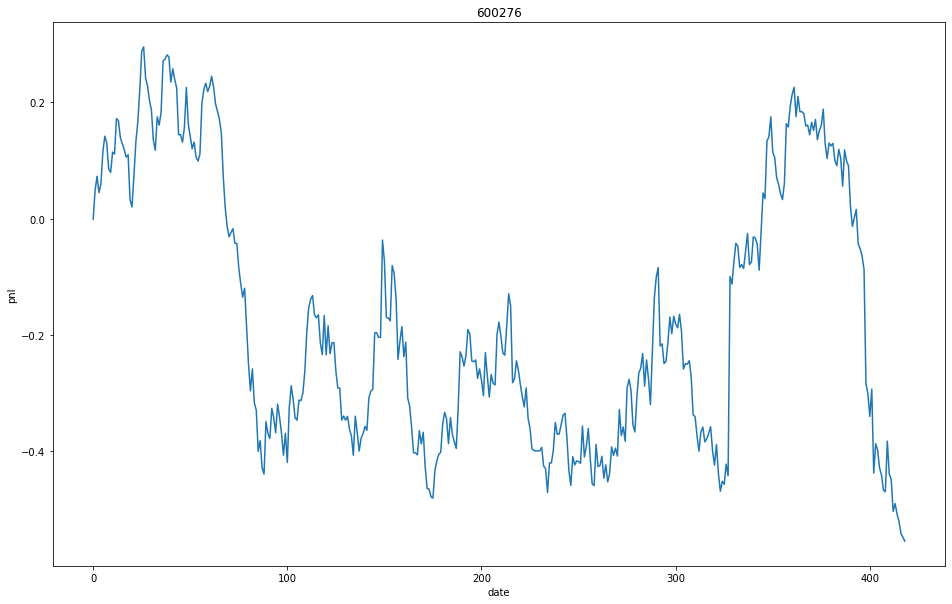

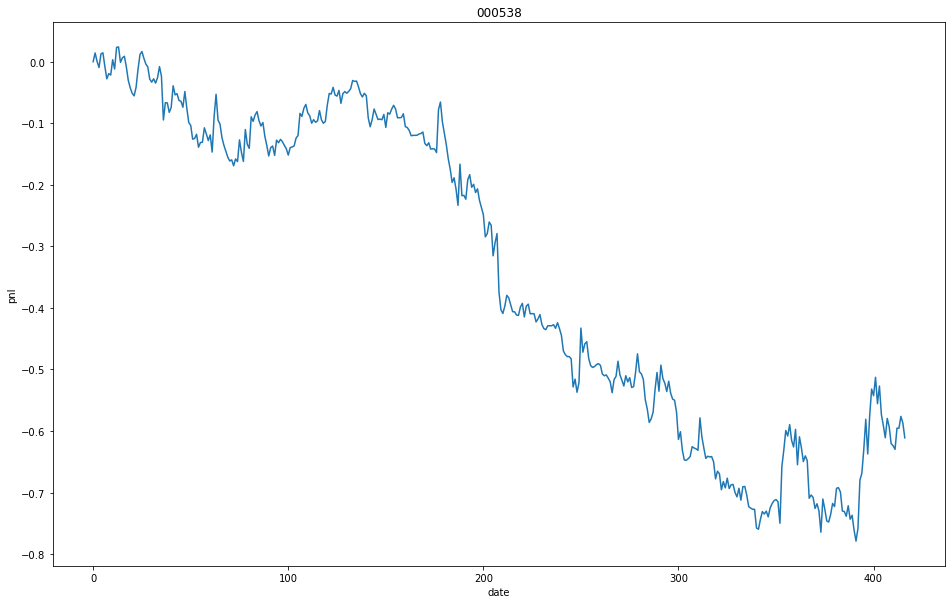

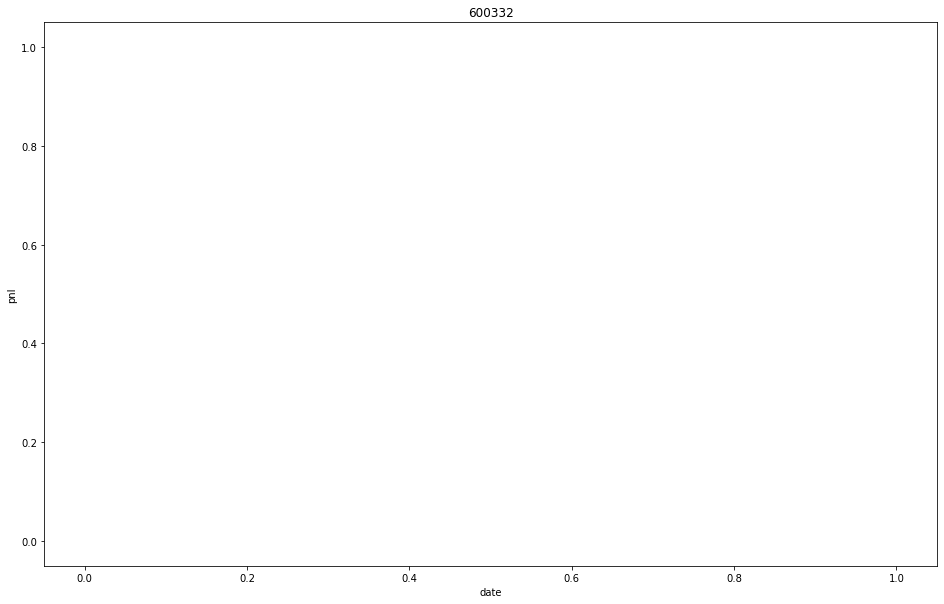

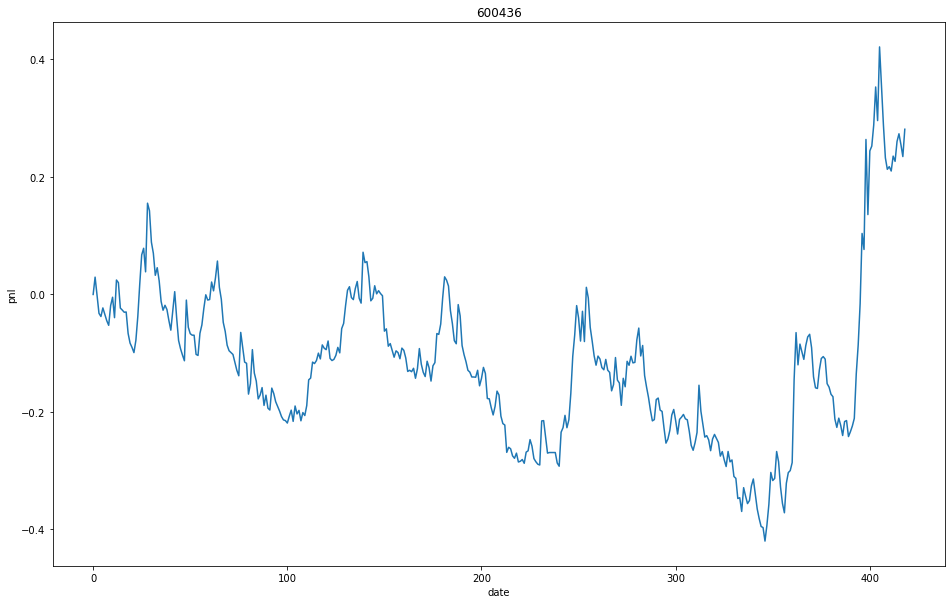

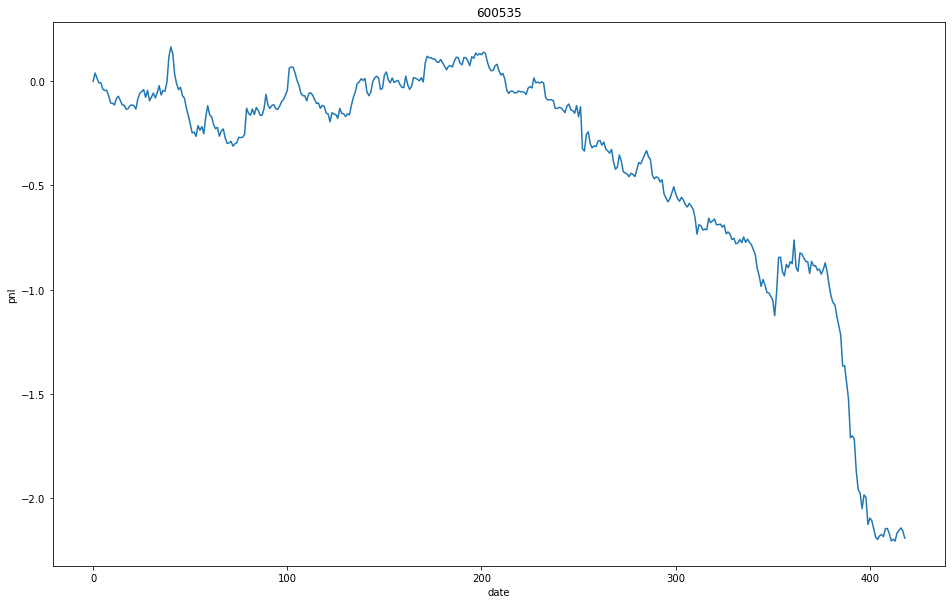

In [376]:
i = 0
for product in product_list:
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.ret"]>0.001) & (trade_stat["final.result"]["num"]>20)
    train_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    trade_stat = test_trade_stat[product]
    test_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(test_pnl.cumsum());

#600276 train sharpe  0.2066881127272283 test sharpe  -0.4751186954929024
#000538 train sharpe  0.43227143235031257 test sharpe  -1.0833159145217328
#600332 train sharpe  nan test sharpe  nan
#600436 train sharpe  0.5561075601133421 test sharpe  0.3291402713208131
#600535 train sharpe  0.2260027836219714 test sharpe  -2.188983053115565







- now calculate the result of test samples

- Homework:
- you can try using total.trade.imb.4096 to test again
- you can try using 1024/2048 to repeat this process and compare the result
- you can change the atr threshold of 20 to other values
- you can change the split of train/test samples
- you can try using reverse=1 and -1